In [1]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [2]:
source("../../src/Variacion/functions.R")
source("../../src/general.R")

# Data variables

In [3]:
municipio = c("Santander")
site = ""#c("es1580a", "es0118a")

data.by.file = TRUE

pollutant = c("no2", "no", "o3")#, "pm10", "pm2.5")
start_dt = 2013

# Lockdown dates

In [4]:
periods <- list(
    # Prelockdown
    pre.lockdown = ymd_hms("2020-01-01 00:00:00"),

    # lockdown
    lockdown = ymd_hms("2020-03-14 00:00:00"),
    #end.lockdown = ymd_hms("2020-04-28 00:00:00"),

    # poslockdown
    fases = ymd_hms("2020-05-01 00:00:00"),
    normalidad = ymd_hms("2020-06-21 00:00:00"),

    # New lockdown
    new.lockdown = ymd_hms("2020-10-25 00:00:00"),
    end.year = ymd_hms("2020-12-31 00:00:00")
)

---

In [5]:
if (site == "" && municipio != "") {
    site <- get.site.municipio(municipio,
                               fileName="../../data/curation/sitesAQ.csv")
}

In [6]:
data.AQ <- get.AQdata(site, pollutant, start_dt, data.by.file)
head(data.AQ)

date,date_end,site,variable,process,summary,validity,unit,value
<dttm>,<dttm>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<dbl>
2013-01-01 00:00:00,2013-01-01 01:00:00,es1580a,no2,118046,1,1,ug.m-3,45
2013-01-01 01:00:00,2013-01-01 02:00:00,es1580a,no2,118046,1,1,ug.m-3,28
2013-01-01 02:00:00,2013-01-01 03:00:00,es1580a,no2,118046,1,1,ug.m-3,16
2013-01-01 03:00:00,2013-01-01 04:00:00,es1580a,no2,118046,1,1,ug.m-3,5
2013-01-01 04:00:00,2013-01-01 05:00:00,es1580a,no2,118046,1,1,ug.m-3,6
2013-01-01 05:00:00,2013-01-01 06:00:00,es1580a,no2,118046,1,1,ug.m-3,7


# Calculo Propio de Media diaria

## `saqgetr` Media diaria

Para el caso de SANTANDER CENTRO no te devuelve ningun dato con resolucion diaria, y para el caso de Madrid ESCUELAS AGUIRRE de algunos contaminantes si te devuelve la resolucion diaria, pero en concreto para el NO2. Suponemos que `saq_clean_observations()` maneja los `NA` de alguna manera especial de tal forma que cuando hasy demasiados como para no poder hacer la media no te devuelve nada.

(No usaran `na.rm`??????)

```R
data.AQ.cln <- saq_clean_observations(data.AQ,
                                      summary = "day",
                                      valid_only = TRUE,
                                      #spread = TRUE
                                     )
head(data.AQ.cln)
```

In [7]:
data.AQ.dy <- data.AQ %>%
                group.dy(unit="day", FUN=mean)

# Comparar Datos por Año

In [8]:
data.all <- compare.years(data.AQ.dy, last.yr=2020)
head(data.all)

,date,variable,site,2020,2019,2013-2019
,<dttm>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,2020-01-01,no,es1580a,8.583333,11.09722,9.518353
2,2020-01-01,no2,es1580a,36.375000,24.77778,33.634921
3,2020-01-02,no,es1580a,50.125000,NA,32.982391
4,2020-01-02,no2,es1580a,45.166667,NA,51.989831
5,2020-01-03,no,es1580a,27.125000,NA,24.755208
6,2020-01-03,no2,es1580a,51.333333,NA,45.454861


## Variacion de las medias en cada periodo

In [9]:
# Calcular Medias
columns <- c("2020", 
             "2019", 
             paste(start_dt, "-2019", sep=""))
medias <- mean.in.period(data.all, periods, columns)

head(medias)

,period,site,variable,mean(2020),std(2020),mean(2019),std(2019),mean(2013-2019),std(2013-2019)
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,pre.lockdown,es1580a,no2,38.18031,10.125399,29.01479,8.235409,36.97726,5.550580
2,lockdown,es1580a,no2,16.31201,8.500863,27.88963,9.769029,31.62240,4.496294
3,fases,es1580a,no2,15.16972,5.635807,19.74131,7.493195,25.34550,2.871883
4,normalidad,es1580a,no2,13.91232,4.934940,25.70724,9.241215,28.02786,4.293795
5,new.lockdown,es1580a,no2,12.83651,5.556742,36.20492,11.350584,38.70911,6.278111
6,pre.lockdown,es1580a,no,17.06427,13.603537,13.90237,7.066698,15.01830,5.393279


In [10]:
# Calcular variaciones
var.med <- get.difference(medias, "mean(2020)", c("mean(2019)",
                                                  paste("mean(", start_dt, "-2019)", sep="")),
                                  mainSTD="std(2020)", restSTD=c("std(2019)",
                                                                 paste("std(", start_dt, "-2019)", sep="")))
var.med[,4:ncol(var.med)] <- var.med[,4:ncol(var.med)]*100

In [11]:
var.med[var.med$site == site[1] &
        var.med$variable == pollutant[1] &
        var.med$period %in% names(periods)
       ,]

,period,site,variable,mean(2019).vs.mean(2020),std(2019).vs.std(2020),mean(2013-2019).vs.mean(2020),std(2013-2019).vs.std(2020)
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,pre.lockdown,es1580a,no2,31.58914,-2.4522166,3.253508,11.883602
2,lockdown,es1580a,no2,-41.51225,9.9936009,-48.416262,19.547873
3,fases,es1580a,no2,-23.15749,-0.6187650,-40.148276,15.454167
4,normalidad,es1580a,no2,-45.88169,-0.2577067,-50.362529,10.002935
5,new.lockdown,es1580a,no2,-64.54485,4.2325069,-66.838534,8.976773


## Compara datos con los obtenidos del CIMA

In [12]:
if ("es1580a" %in% site & "no2" %in% pollutant) {
    vs.CIMA <- data.frame(source=c("CIMA", "CIMA", "R", "R"),
                          years=c("vs2019", "vs2015-19", "vs2019", "vs2015-19"),
                          pre.lockdown = c( 20.2,   0.8,  31.6, -2.3 ),
                          lockdown     = c(-40.9, -47.5, -41.1, -47.4),
                          fases        = c(-26.7, -42.0, -23.2, -39.3),
                          Normalidad   = c(-46.0, -49.3, -45.9, -49.1),
                          "2.lockdown" = c(-61.7, -65.0, -62.7, -66.2)
                         )

    vs.CIMA[3, 3:7] <- var.med[var.med$site == "es1580a" &
                                           var.med$variable == "no2" &
                                           var.med$period %in% names(periods)
                                           , 4]
    vs.CIMA[4, 3:7] <- var.med[var.med$site == "es1580a" &
                                           var.med$variable == "no2" &
                                           var.med$period %in% names(periods)
                                           , 6]

    vs.CIMA
}

source,years,pre.lockdown,lockdown,fases,Normalidad,X2.lockdown
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CIMA,vs2019,20.200000,-40.90000,-26.70000,-46.00000,-61.70000
CIMA,vs2015-19,0.800000,-47.50000,-42.00000,-49.30000,-65.00000
R,vs2019,31.589139,-41.51225,-23.15749,-45.88169,-64.54485
R,vs2015-19,3.253508,-48.41626,-40.14828,-50.36253,-66.83853


## Media de las variaciones en cada periodo

In [13]:
# Calcular variaciones
var.med <- get.difference(data.all, "2020",c("2019", 
                                             paste(start_dt, "-2019", sep="")))
var.med[,4:ncol(var.med)] <- var.med[,4:ncol(var.med)]*100
var.med <- filter.by.std(var.med, c("2019.vs.2020", 
                                    paste(start_dt, "-2019.vs.2020", sep="")), 3)


# Calcular Medias
columns <- c("2019.vs.2020", 
             paste(start_dt, "-2019.vs.2020", sep=""))
medias <- mean.in.period(var.med, periods, columns)

medias[medias$site == site[1] &
        medias$variable == pollutant[1] &
        medias$period %in% names(periods)
       ,]

,period,site,variable,mean(2019.vs.2020),std(2019.vs.2020),mean(2013-2019.vs.2020),std(2013-2019.vs.2020)
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,pre.lockdown,es1580a,no2,33.745269,59.15855,4.114379,27.47389
2,lockdown,es1580a,no2,-34.182743,44.61839,-48.044779,27.26848
3,fases,es1580a,no2,-7.970404,56.35111,-38.912751,24.40933
4,normalidad,es1580a,no2,-37.131488,36.48433,-49.486520,18.90647
5,new.lockdown,es1580a,no2,-58.570578,21.60709,-64.494484,15.88528


# Representar Resultados

## Serie temporal de las variaciones diarias

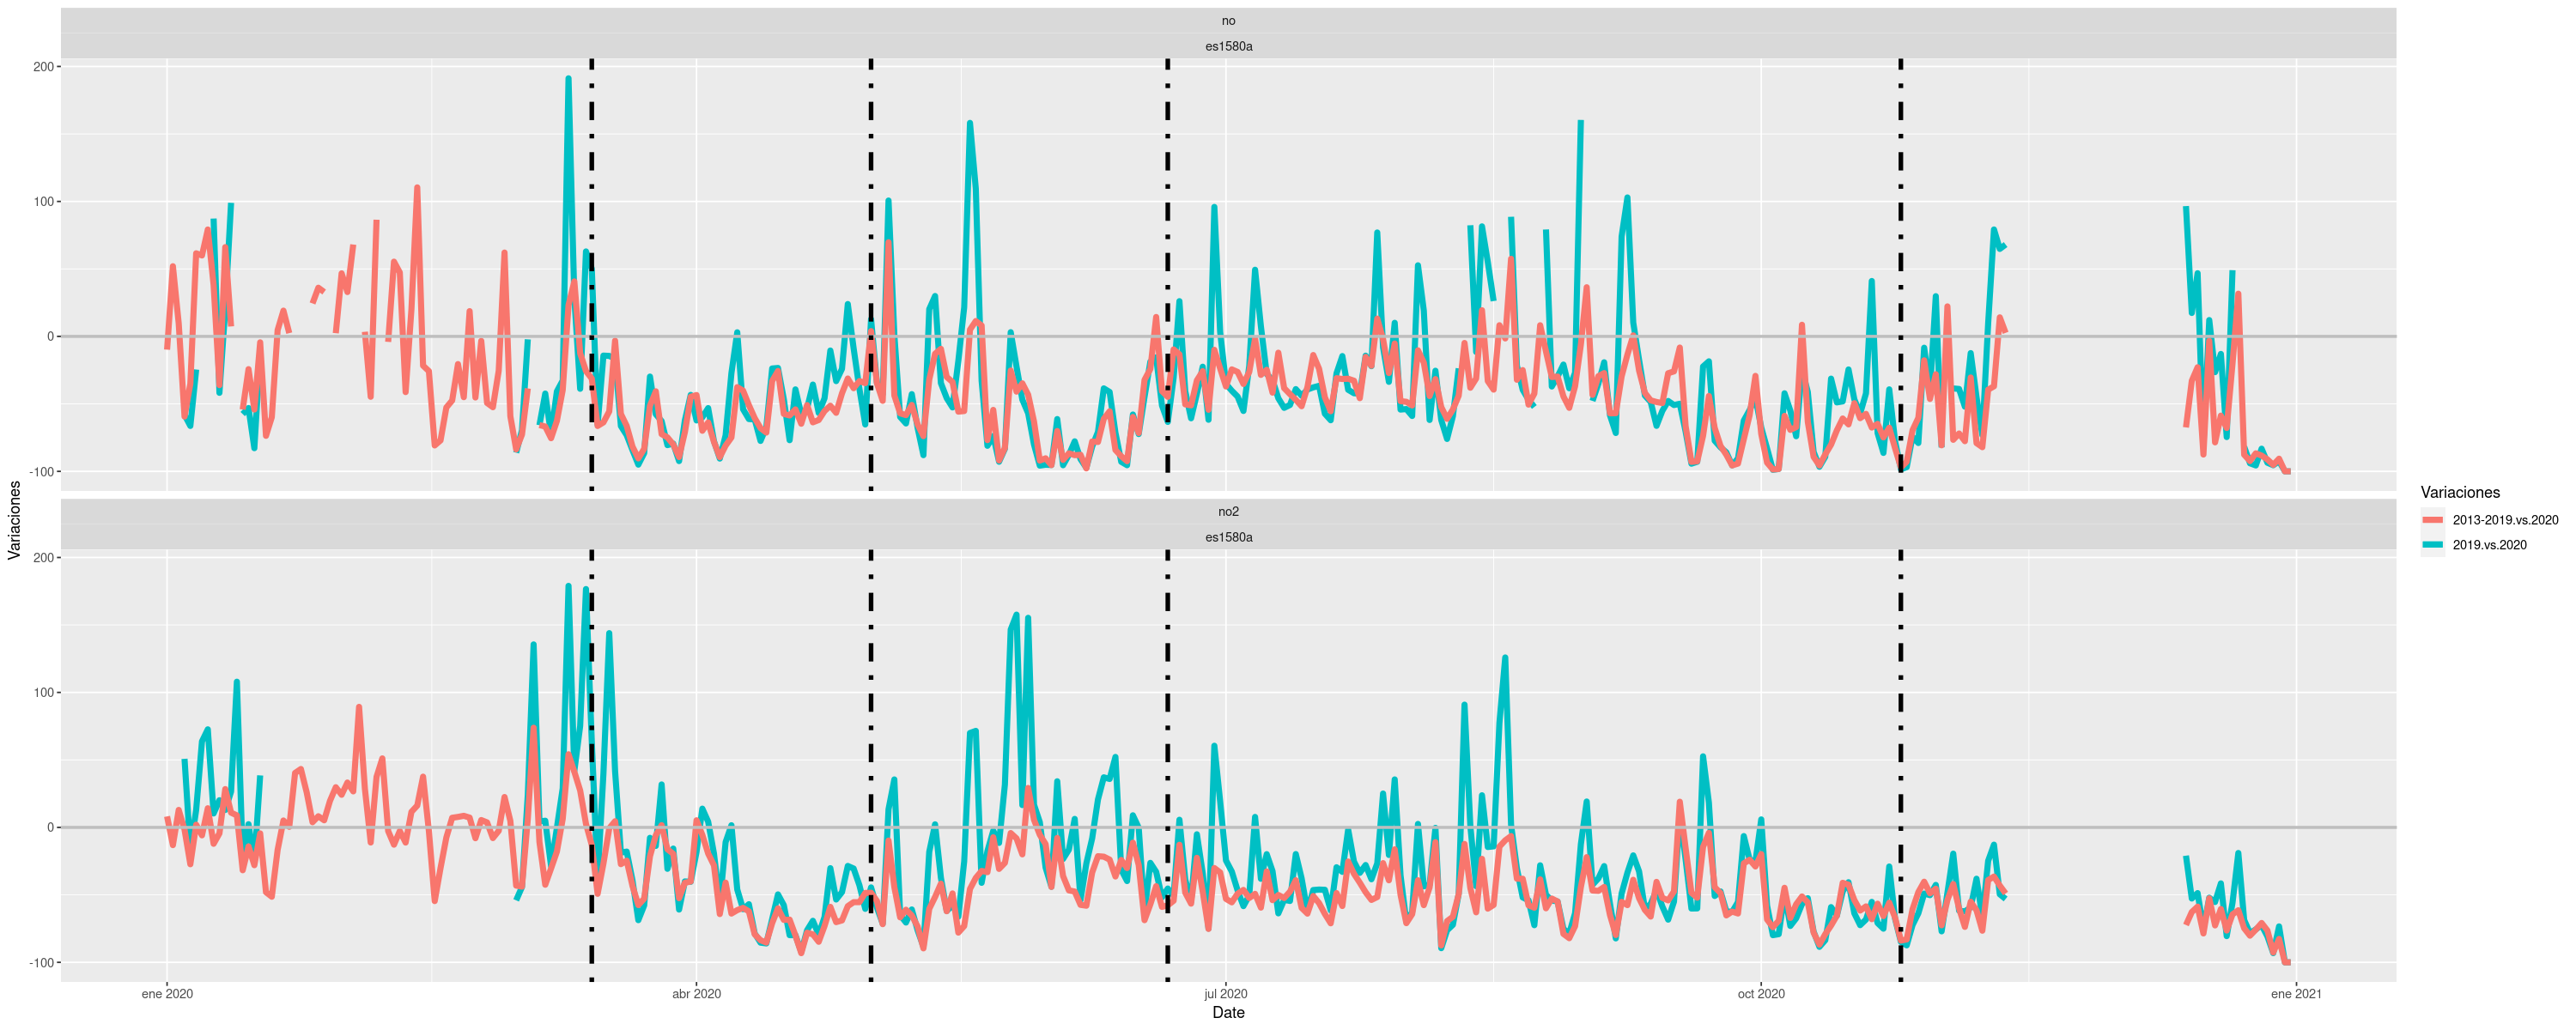

In [14]:
plot.data(var.med, c("2019.vs.2020", 
                     paste(start_dt, "-2019.vs.2020", sep="")), periods, type="var")

## Series temporales de los datos de la Concentracion 

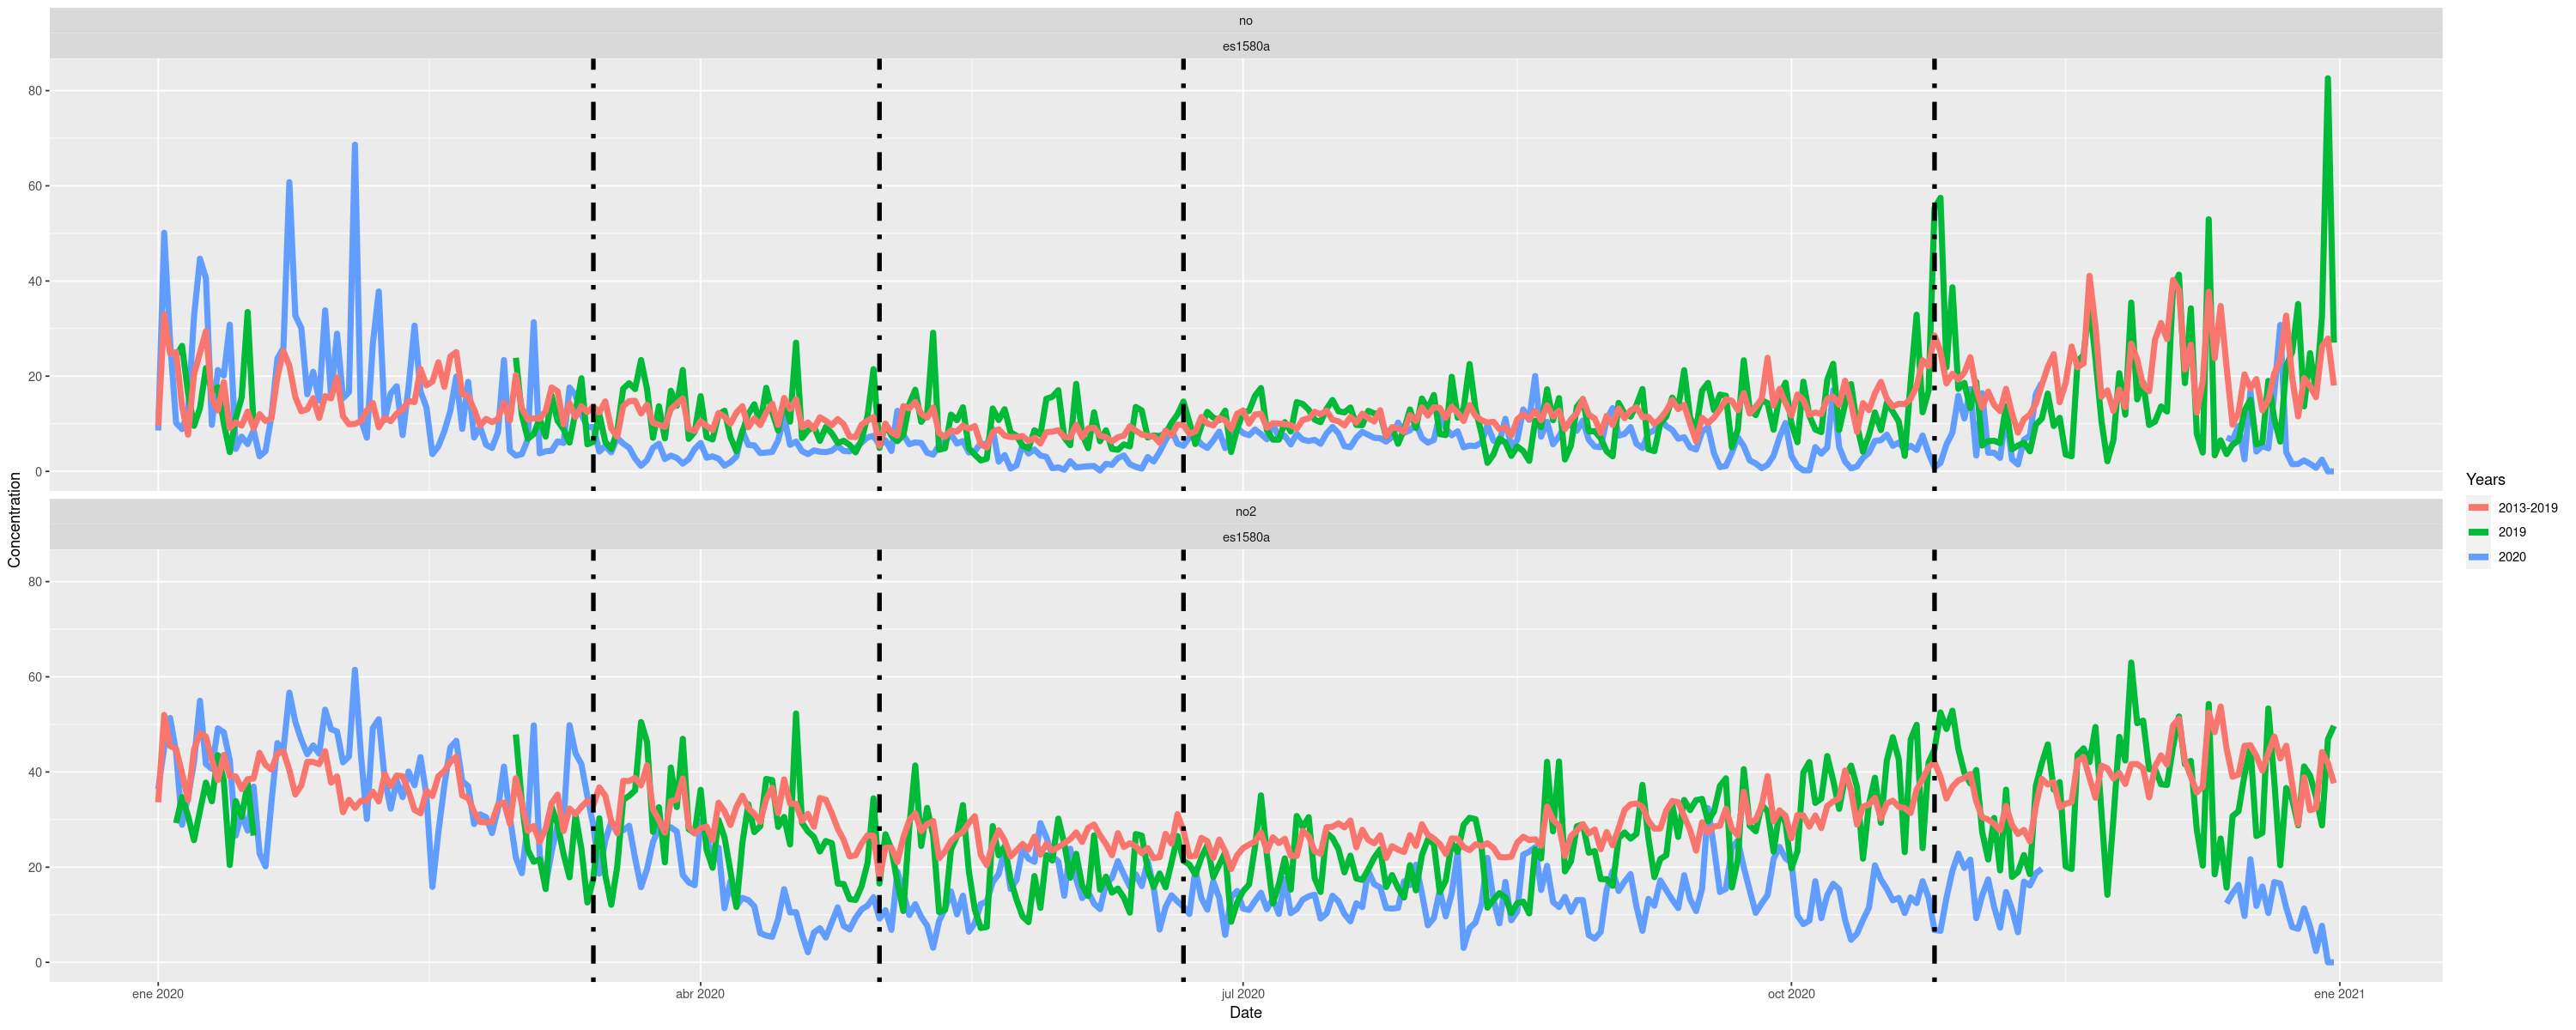

In [15]:
plot.data(data.all, c("2020", 
                      "2019",
                      paste(start_dt, "-2019", sep="")), periods, type="aq")